Código disponível [na minha página do Github](https://github.com/arthurkenzo/atividades_ia525)

## Questão 1:
A problema de filtragem com regularização de Tikhonov é definido pela função objetivo

$$ \min_{u \in \mathbb{R}^n} \| u - x_c\|_2^2 + \delta \| Du \|_2^2. $$

Podemos reescrever uma soma de quadrados de normas $L_2$ em termos da norma de uma única matrix aumentada da seguinte forma:

$$ \| Au - B\|_2^2 + \| Cu - D\|_2^2 = \left\| {\begin{pmatrix} A \\ C \end{pmatrix}} u + {\begin{pmatrix} B \\ D \end{pmatrix}} \right\|_2^2 $$

No caso da regularização de Tikhonov, temos $A = \mathbb{1}$, $B = x_c$, $C = \delta D$ e $D = 0$. Assim, podemos construir uma função objetivo equivalente àquela de um problema de mínimos quadrados. O problema obtido acima tem função objetivo quadrática e não tem restrições, sendo então convexo.

Para a regularização LASSO, é possível remodelar o termo em módulo da função objetivo por meio da adição de um termo linear na função objetivo e de restrições adicionais sobre o novo termo. Para uma variável real, temos:

$$ \begin{align*}
    \text{Minimize }    & | x | \\
\end{align*} \quad\implies\quad \begin{align*}
    \text{Minimize }    & t \\
    \text{ subject to } & -t \leq x \leq t \\
                        &  t \geq 0
\end{align*}  $$

Podemos então generalizar esse método para variáveis vetoriais, adicionando um vetor $t$ de dimensão igual a $u$ à função objetivo, junto com um conjunto de restrições $-t_i \leq d^\mathsf{T}_iu_i \leq t_i\, \forall i$, obtendo assim as formulações equivalentes:

$$ \begin{align*}
    \text{Minimize }    & \| u - x_c\|_2^2 + \delta \| Du \|_1 \\
\end{align*} \quad\implies\quad \begin{align*}
    \text{Minimize }    & \| u - x_c\|_2^2 + t \\
    \text{ subject to } & -t_i \leq \delta d^\mathsf{T}_iu_i \leq t_i\quad \forall i \\
                        &  t \geq 0
\end{align*}  $$

Note que agora temos uma função objetivo quadrática, com restrições apenas lineares, o que torna deste um problema convexo tal qual a regularização de Tikhonov. 



## Implementações dos dois métodos de filtragem

In [1]:
import cvxpy as cp
import numpy as np
import mosek
import matplotlib.pyplot as plt
import time

from typing import Tuple

### Gerando amostragens de sinais para teste 

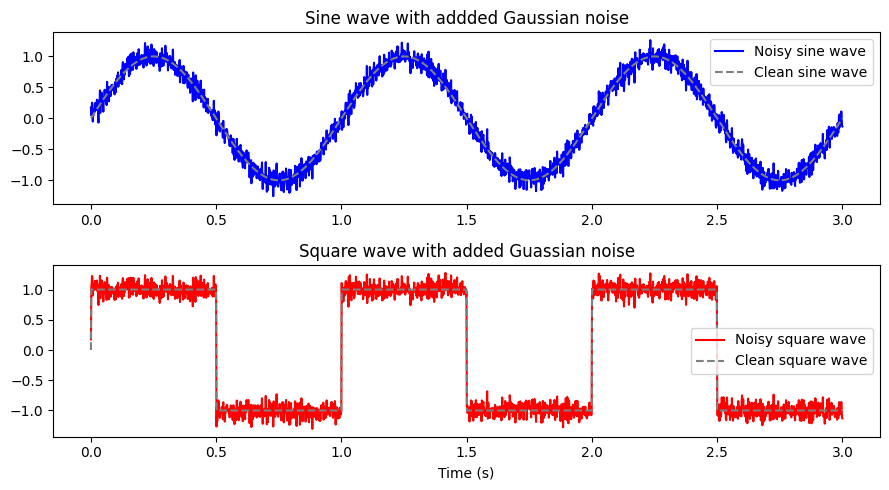

In [12]:
samples = 2000  # samples generated  
periods = 3     # wave parameters for signal generation 
frequency = 1     
amplitude = 1.0   
noise_std = 0.1 # standard deviation for the gaussian noise  

# defining time steps 
t = np.linspace(0, periods / frequency, samples)

# generating signal arrays
sinusoidal = amplitude * np.sin(2 * np.pi * frequency * t)
square_wave = amplitude * np.sign(np.sin(2 * np.pi * frequency * t))

# generating noise array
np.random.seed(0) 
noise = np.random.normal(0, noise_std, size=samples)

# adding noise to signals
noisy_sinusoidal = sinusoidal + noise
noisy_square = square_wave + noise

# Plotting
plt.figure(figsize=(9, 5))

plt.subplot(2, 1, 1)
plt.plot(t, noisy_sinusoidal, label="Noisy sine wave", color='blue')
plt.plot(t, sinusoidal, label="Clean sine wave", color='gray', linestyle='--')
plt.legend()
plt.title("Sine wave with addded Gaussian noise")

plt.subplot(2, 1, 2)
plt.plot(t, noisy_square, label="Noisy square wave", color='red')
plt.plot(t, square_wave, label="Clean square wave", color='gray', linestyle='--')
plt.legend()
plt.title("Square wave with added Guassian noise")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

### Montagem dos programas qudráticos e funções auxiliares

### Filtragem dos sinais de teste